In [23]:
import scipy.io
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import svm
from sklearn import cross_validation

train = scipy.io.loadmat('labeled_images.mat')
print "Shape of tr_images is: ", train["tr_images"].shape

Shape of tr_images is:  (32, 32, 2925)


In [20]:
# Make sure that caffe is on the python path:
caffe_root = '/u/zexuan/caffe/caffe/'  # this file is expected to be in {caffe_root}/examples
caffe_real_root = '/pkgs/caffe/'
thesis_root = '/ais/gobi2/pingpong/thesis/'
#!ls /pkgs/caffe
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os
if not os.path.isfile('~/caffe/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !~/caffe/caffe/scripts/download_model_binary.py ~/caffe/caffe/models/bvlc_reference_caffenet

Model already exists.


In [38]:
caffe.set_mode_cpu()
print caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
#!ls caffe_root+'models/bvlc_reference_caffenet/deploy.prototxt'
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
print net.blobs['data'].data.shape

/u/zexuan/caffe/caffe/models/bvlc_reference_caffenet/deploy.prototxt
(10, 3, 227, 227)


In [37]:
#net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))
print 'img shape: ', caffe.io.load_image(thesis_root + 'final_output/bottom_player_winning/point_00003/frame_00377.png').shape
#print 'tr_images shape: ',train["tr_images"][0].shape
(x, y, n_images) = train["tr_images"].shape
train_img = np.swapaxes(train["tr_images"], 0, 2)
print train_img[0].shape

#net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(thesis_root + 'final_output/bottom_player_winning/point_00003/frame_00377.png'))
net.blobs['data'].data[...] = transformer.preprocess('data', train_img[0])
out = net.forward()
print("Predicted class is #{}.".format(out['prob'][0].argmax()))
print transformer.deprocess('data', net.blobs['data'].data[0]).shape
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

img shape:  (720, 1280, 3)
(32, 32)


RuntimeError: sequence argument must have length equal to input rank

(2925, 1024)
[122 120 117 ...,  30  29  22]
[ 6  6  6 ..., 50 44 39]


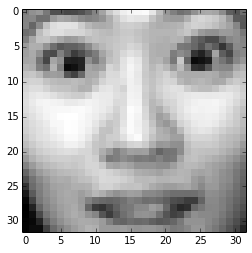

In [26]:
(x, y, n_images) = train["tr_images"].shape

train_img = np.reshape(np.swapaxes(train["tr_images"], 0, 2), (n_images, x * y))
print train_img.shape
print train_img[100]
print train_img[-1]
plt.imshow(np.swapaxes(np.reshape(train_img[0], (y, x)), 0, 1), cmap=pylab.gray())
plt.show()

In [19]:
#for c in [0.001, 1, 100]:
#    print c
clf = svm.SVC(kernel='poly', degree=3, C=100)
scores = cross_validation.cross_val_score(clf, train_img, np.reshape(train["tr_labels"], (n_images, )) , cv=5)
print scores
print scores.mean()

[ 0.72307692  0.73162393  0.71794872  0.71965812  0.73162393]
0.724786324786
